,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,57.4717,28435.7033,150.2049,0.9129,0.1354,0.1042,0.0920
knn,K Neighbors Regressor,61.5163,21654.4012,134.2148,0.9229,0.1421,0.1219,0.0440
lightgbm,Light Gradient Boosting Machine,84.8242,28738.8093,163.6827,0.8906,0.2015,0.1749,0.1000
gbr,Gradient Boosting Regressor,84.9788,30109.4011,167.2545,0.8964,0.2017,0.1794,0.0560
xgboost,Extreme Gradient Boosting,85.8859,31981.1955,171.0986,0.8942,0.1999,0.1779,0.0760
catboost,CatBoost Regressor,86.6655,32576.2140,173.0789,0.8924,0.2011,0.1792,0.4720
rf,Random Forest Regressor,87.1253,31067.2672,169.4266,0.8936,0.2012,0.1798,0.1040
dt,Decision Tree Regressor,88.1423,35928.0814,179.2855,0.8865,0.2032,0.1793,0.0500
llar,Lasso Least Angle Regression,100.2569,33487.5489,160.5791,0.8567,0.4793,0.3465,0.0480
en,Elastic Net,103.4087,38086.3516,175.6276,0.8424,0.2932,0.2698,1.1720


                                    Model       MAE         MSE      RMSE  \
et                  Extra Trees Regressor   57.4717  28435.7033  150.2049   
knn                 K Neighbors Regressor   61.5163  21654.4012  134.2148   
lightgbm  Light Gradient Boosting Machine   84.8242  28738.8093  163.6827   
gbr           Gradient Boosting Regressor   84.9788  30109.4011  167.2545   
xgboost         Extreme Gradient Boosting   85.8859  31981.1955  171.0986   
catboost               CatBoost Regressor   86.6655  32576.2140  173.0789   
rf                Random Forest Regressor   87.1253  31067.2672  169.4266   
dt                Decision Tree Regressor   88.1423  35928.0814  179.2855   
llar         Lasso Least Angle Regression  100.2569  33487.5489  160.5791   
en                            Elastic Net  103.4087  38086.3516  175.6276   

              R2   RMSLE    MAPE  TT (Sec)  
et        0.9129  0.1354  0.1042     0.092  
knn       0.9229  0.1421  0.1219     0.044  
lightgbm  0.8906 

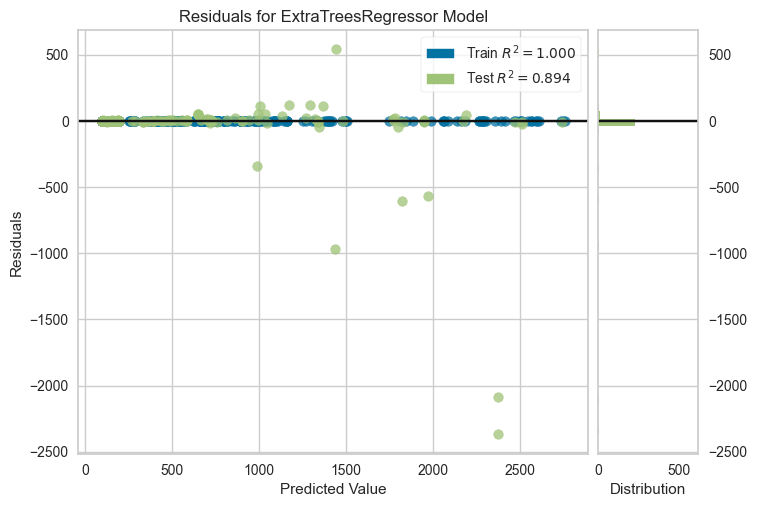

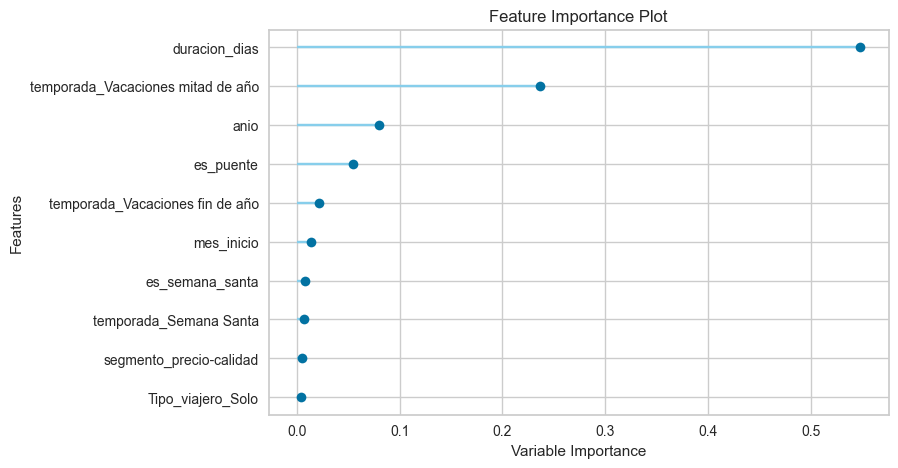

In [3]:
import pandas as pd
from pycaret.regression import *

ruta = r"C:\Users\FABIO\Downloads\temporadas_seg_tipo_personas_2020_2024_50k_FLAT.csv"
df50 = pd.read_csv(ruta, encoding="utf-8-sig")

# 1) Agregar al nivel correcto (TARGET útil)
keys = ["temporada","anio","segmento","Tipo_viajero",
        "duracion_dias","mes_inicio","es_evento_ciudad","es_semana_santa","es_navidad","es_puente"]
train = (df50
         .groupby(keys, as_index=False)["personas"]
         .sum()
         .rename(columns={"personas":"personas_total"}))

# 2) PyCaret en REGRESIÓN
exp = setup(
    data=train,
    target="personas_total",
    fold=5,
    fold_strategy="groupkfold",   # no mezclar años entre folds
    fold_groups=train["anio"],
    categorical_features=["temporada","segmento","Tipo_viajero"],
    numeric_features=["anio","duracion_dias","mes_inicio",
                      "es_evento_ciudad","es_semana_santa","es_navidad","es_puente"],
    session_id=42,
    verbose=False
)

best = compare_models(sort="MAE")
print(pull().head(10))
plot_model(best, plot="residuals")
plot_model(best, plot="feature")


In [4]:
# asumiendo 'setup(...)' ya corrido con groupkfold por 'anio'
top_mae   = create_model('et')     # ExtraTrees
top_rmse  = create_model('knn')    # KNN

t_et  = tune_model(top_mae,  optimize='MAE')
t_knn = tune_model(top_rmse, optimize='RMSE')

evaluate_model(t_et)
evaluate_model(t_knn)

# ranking final por tu métrica clave (ej. MAE)
blend = compare_models(include=[t_et, t_knn], sort='MAE')
final = finalize_model(blend)
save_model(final, 'modelo_temporadas_personas')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61.8431,50813.5102,225.4185,0.8858,0.1389,0.0556
1,76.9900,21195.6147,145.5871,0.9573,0.1154,0.0999
2,38.7248,7982.7159,89.3460,0.9787,0.0854,0.0609
3,102.2991,25756.8431,160.4894,0.8092,0.2763,0.3171
4,27.7245,2523.3223,50.2327,0.9838,0.0946,0.0760
Mean,61.5163,21654.4012,134.2148,0.9229,0.1421,0.1219
Std,26.6988,16853.5297,60.3390,0.0668,0.0696,0.0988


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63.8260,61050.6685,247.0843,0.8628,0.1557,0.0484
1,73.1737,15120.6388,122.9660,0.9695,0.1186,0.1044
2,27.6691,3541.4129,59.5098,0.9905,0.0552,0.0413
3,128.5151,38652.4472,196.6023,0.7137,0.3240,0.3762
4,19.0000,947.6393,30.7838,0.9939,0.0563,0.0493
Mean,62.4368,23862.5613,131.3892,0.9061,0.1419,0.1239
Std,38.9335,22874.2649,81.2369,0.1075,0.0987,0.1282


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,56.3263,50821.9420,225.4372,0.8858,0.1383,0.0483
1,68.6909,16242.2332,127.4450,0.9672,0.1090,0.0940
2,27.8838,4439.9207,66.6327,0.9881,0.0608,0.0420
3,117.0651,37087.4006,192.5809,0.7253,0.2976,0.3445
4,14.1233,628.1224,25.0624,0.9960,0.0588,0.0471
Mean,56.8179,21843.9238,127.4316,0.9125,0.1329,0.1152
Std,35.8635,19269.0301,74.8672,0.1014,0.0876,0.1162


Fitting 5 folds for each of 10 candidates, totalling 50 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
1,K Neighbors Regressor,56.8179,21843.9238,127.4316,0.9125,0.1329,0.1152,0.0440
0,Extra Trees Regressor,57.4717,28435.7033,150.2049,0.9129,0.1354,0.1042,0.0820


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['anio', 'duracion_dias',
                                              'mes_inicio', 'es_evento_ciudad',
                                              'es_semana_santa', 'es_navidad',
                                              'es_puente'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['temporada', 'segmento',
                                              'Tipo_viajero'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['temporada', 'segmento',
                                              'Tipo_viajero'],
                                     transformer=OneHotEncoder(cols=['temporada',
                                           